# NBA Shot Success Deep Learning Model

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import re

sns.set(style='white')

## Data Loading

In [2]:
nba_df = pd.read_csv('shot_logs.csv')
nba_df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [79]:
matchup = nba_df['matchup'].str.split('-')
n=0
teams = []
for i in matchup:
    hold = re.sub(r'[\s+]', '', matchup[n][1])
    teams.append(hold)
    n+=1
nba_df['teams'] = teams

In [93]:
nba_df['teams']

0           CHA@BKN
1           CHA@BKN
2           CHA@BKN
3           CHA@BKN
4           CHA@BKN
5           CHA@BKN
6           CHA@BKN
7           CHA@BKN
8           CHA@BKN
9         CHAvs.LAL
10        CHAvs.LAL
11        CHAvs.LAL
12        CHAvs.LAL
13          CHA@ORL
14          CHA@BOS
15          CHA@BOS
16          CHA@BOS
17          CHA@BOS
18          CHA@BOS
19          CHA@CHI
20          CHA@CHI
21          CHA@CHI
22          CHA@CHI
23          CHA@CHI
24          CHA@CHI
25          CHA@CHI
26          CHA@CHI
27          CHA@DAL
28          CHA@DAL
29          CHA@DAL
            ...    
128039    BKNvs.NYK
128040    BKNvs.NYK
128041    BKNvs.NYK
128042    BKNvs.NYK
128043    BKNvs.MIN
128044    BKNvs.MIN
128045    BKNvs.MIN
128046    BKNvs.MIN
128047    BKNvs.MIN
128048    BKNvs.MIN
128049    BKNvs.MIN
128050    BKNvs.MIN
128051    BKNvs.OKC
128052    BKNvs.OKC
128053    BKNvs.OKC
128054    BKNvs.OKC
128055    BKNvs.OKC
128056      BKN@DET
128057      BKN@DET


In [31]:
nba_df.describe()

,game_id,final_margin,shot_number,period,shot_clock,dribbles,touch_time,shot_dist,pts_type,closest_defender_player_id,close_def_dist,fgm,pts,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


The dataset looks fairly clean from this perspective. Free throws are not included, overtimes are, the final margin is measured in reference to the team. If the team loses then the final_margin is negative. It would be useful to seperate out the matchup column into a mathup date and matchup team column.

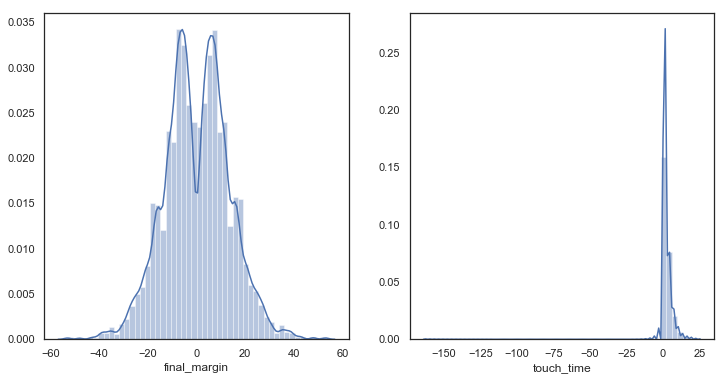

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(
    nba_df['final_margin']
)

plt.subplot(1,2,2)
sns.distplot(
    nba_df['touch_time']
)
plt.show()

In [43]:
nba_df.loc[nba_df['touch_time'] < 0]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
748,21400625,"JAN 21, 2015 - CHA vs. MIA",H,W,2,7,4,7:55,9.0,0,...,7.5,2,made,"napier, shabazz",203894,3.9,1,2,al jefferson,2744
775,21400459,"DEC 29, 2014 - CHA vs. MIL",H,L,-10,12,4,7:34,6.3,0,...,4.1,2,missed,"henson, john",203089,0.1,0,0,al jefferson,2744
1043,21400195,"NOV 23, 2014 - CHA @ MIA",A,L,-1,17,4,0:02,NaN,0,...,1.3,2,missed,"williams, shawne",200761,1.3,0,0,al jefferson,2744
1118,21400130,"NOV 14, 2014 - CHA @ PHX",A,W,8,7,2,5:36,17.7,0,...,5.0,2,made,"plumlee, miles",203101,3.7,1,2,al jefferson,2744
1260,21400028,"NOV 01, 2014 - CHA vs. MEM",H,L,-2,9,3,11:00,23.7,0,...,8.4,2,missed,"conley, mike",201144,0.6,0,0,al jefferson,2744
1860,21400444,"DEC 27, 2014 - CHA vs. ORL",H,L,-8,7,2,7:18,12.3,0,...,19.7,2,made,"o'quinn, kyle",203124,9.8,1,2,gary neal,202390
2173,21400816,"FEB 21, 2015 - CHA vs. OKC",H,L,-7,8,4,10:53,0.2,0,...,20.6,2,missed,"morrow, anthony",201627,3.4,0,0,gerald henderson,201945
2202,21400761,"FEB 07, 2015 - CHA @ PHI",A,L,-8,5,1,3:41,21.1,0,...,17.5,2,missed,"thompson, hollis",203138,3.8,0,0,gerald henderson,201945
3194,21400172,"NOV 21, 2014 - CHA vs. ORL",H,L,-5,16,4,2:30,3.7,0,...,4.7,2,made,"payton, elfrid",203901,1.9,1,2,kemba walker,202689
4170,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,2,0:32,16.2,0,...,2.6,2,missed,"young, thaddeus",201152,0.1,0,0,marvin williams,101107


## Data Cleaning

In [23]:
#checking for duplicated rows
duplicates = nba_df.duplicated()
n = 0
for i in duplicates:
    if i is True:
        n += 1
print('Number of duplicate rows in the dataset:', n)

Number of duplicate rows in the dataset: 0


In [24]:
nba_df.columns = map(str.lower, nba_df.columns)
nba_df['closest_defender'] = nba_df['closest_defender'].str.lower()
print(nba_df.columns)
print(nba_df.dtypes)

Index(['game_id', 'matchup', 'location', 'w', 'final_margin', 'shot_number',
       'period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time',
       'shot_dist', 'pts_type', 'shot_result', 'closest_defender',
       'closest_defender_player_id', 'close_def_dist', 'fgm', 'pts',
       'player_name', 'player_id'],
      dtype='object')
game_id                         int64
matchup                        object
location                       object
w                              object
final_margin                    int64
shot_number                     int64
period                          int64
game_clock                     object
shot_clock                    float64
dribbles                        int64
touch_time                    float64
shot_dist                     float64
pts_type                        int64
shot_result                    object
closest_defender               object
closest_defender_player_id      int64
close_def_dist                float64
fgm         

## EDA

In [13]:
print('Number of unique shooters in the dataset:', nba_df['player_name'].nunique())
print('Number of unique defenders in the dataset:', nba_df['closest_defender'].nunique())

Number of unique shooters in the dataset: 281
Number of unique defenders in the dataset: 473


In [27]:
nba_df['closest_defender'].value_counts().head(10)

ibaka, serge       814
jordan, deandre    795
gasol, pau         754
green, draymond    751
millsap, paul      750
chandler, tyson    698
vucevic, nikola    697
frye, channing     693
love, kevin        691
gortat, marcin     688
Name: closest_defender, dtype: int64

In [30]:
nba_df['shot_result'].value_counts() / len(nba_df['shot_result'])

missed    0.547861
made      0.452139
Name: shot_result, dtype: float64

The total dataset has 45% of the shots made, which is pretty good. It's also helpful that the dataset of missed vs. made is fairly well balanced. Thanks to the data coming directly from the NBA REST API, it is pretty clean.